# Enefit - Predict Energy Behavior of Prosumers

The challenge in this competition is to predict the amount of electricity produced and consumed by Estonian energy customers who have installed solar panels. The dataset includes weather data, the relevant energy prices, and records of the installed photovoltaic capacity.

This is a forecasting competition using the time series API.

**Description**

The number of prosumers is rapidly increasing, and solving the problems of energy imbalance and their rising costs is vital. If left unaddressed, this could lead to increased operational costs, potential grid instability, and inefficient use of energy resources. If this problem were effectively solved, it would significantly reduce the imbalance costs, improve the reliability of the grid, and make the integration of prosumers into the energy system more efficient and sustainable. Moreover, it could potentially incentivize more consumers to become prosumers, knowing that their energy behavior can be adequately managed, thus promoting renewable energy production and use.

**About us**

Enefit is one of the biggest energy companies in Baltic region. As experts in the field of energy, we help customers plan their green journey in a personal and flexible manner as well as implement it by using environmentally friendly energy solutions.
At present, Enefit is attempting to solve the imbalance problem by developing internal predictive models and relying on third-party forecasts. However, these methods have proven to be insufficient due to their low accuracy in forecasting the energy behavior of prosumers. The shortcomings of these current methods lie in their inability to accurately account for the wide range of variables that influence prosumer behavior, leading to high imbalance costs. By opening up the challenge to the world's best data scientists through the Kaggle platform, Enefit aims to leverage a broader pool of expertise and novel approaches to improve the accuracy of these predictions and consequently reduce the imbalance and associated costs.

**Evaluation**

Submissions are evaluated on the Mean Absolute Error (MAE) between the predicted return and the observed target. The formula is given by:

𝑀𝐴𝐸=1𝑛∑𝑖=1𝑛|𝑦𝑖−𝑥𝑖|

Where:
* 𝑛 is the total number of data points.
* 𝑦𝑖 is the predicted value for data point i.
* 𝑥𝑖 is the observed value for data point i.

**Submitting**

You must submit to this competition using the provided python time-series API, which ensures that models do not peek forward in time. To use the API, follow the template in this [notebook](https://www.kaggle.com/code/sohier/enefit-basic-submission-demo).

**Timeline**

This is a future data prediction competition with an active training phase and a second period where selected submissions will be evaluated against future ground truth data.

*Training Timeline*

* November 1, 2023 - Start Date.
* January 24, 2024 - Entry Deadline. You must accept the competition rules before this date in order to compete.
* January 24, 2024 - Team Merger Deadline. This is the last day participants may join or merge teams.
* January 31, 2024 - Final Submission Deadline.

All deadlines are at 11:59 PM UTC on the corresponding day unless otherwise noted. The competition organizers reserve the right to update the contest timeline if they deem it necessary.

*Prediction Timeline:*

Starting after the final submission deadline there will be periodic updates to the leaderboard to reflect future data updates that will be evaluated against selected submissions. We anticipate 1-3 interim updates before the final evaluation.

* April 30, 2024 - Competition End Date

**Prizes**

* 1st Place - $ 15,000
* 2nd Place - $ 10,000
* 3rd Place - $ 8,000
* 4th Place - $ 7,000
* 5th Place - $ 5,000
* 6th Place - $ 5,000

**Code Requirements**

Submissions to this competition must be made through Notebooks. In order for the "Submit" button to be active after a commit, the following conditions must be met:

* CPU Notebook <= 9 hours run-time
* GPU Notebook <= 9 hours run-time
* Internet access disabled
* Freely & publicly available external data is allowed, including pre-trained models
* Submission file must be named submission.csv and be generated by the API.

Please see the [Code Competition FAQ](https://www.kaggle.com/docs/competitions#notebooks-only-FAQ) for more information on how to submit. And review the [code debugging doc](https://www.kaggle.com/code-competition-debugging) if you are encountering submission errors.

### Load Workspace

In [1]:
import re
import datetime as dt
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('fivethirtyeight')
import seaborn as sns
import opendatasets as od
import kaggle
import zipfile
import io
import json

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, classification_report

### Load the Dataset

In [2]:
def list_files_in_zip(zip_file_path):
    zip_files = list()
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        file_list = zip_ref.namelist()
        for file in file_list:
            zip_files.append(file)
    return zip_files

zip_file_path = 'predict-energy-behavior-of-prosumers.zip'

enefit_files = list_files_in_zip(zip_file_path)
enefit_files

['client.csv',
 'county_id_to_name_map.json',
 'electricity_prices.csv',
 'enefit/__init__.py',
 'enefit/competition.cpython-310-x86_64-linux-gnu.so',
 'example_test_files/client.csv',
 'example_test_files/electricity_prices.csv',
 'example_test_files/forecast_weather.csv',
 'example_test_files/gas_prices.csv',
 'example_test_files/historical_weather.csv',
 'example_test_files/revealed_targets.csv',
 'example_test_files/sample_submission.csv',
 'example_test_files/test.csv',
 'forecast_weather.csv',
 'gas_prices.csv',
 'historical_weather.csv',
 'public_timeseries_testing_util.py',
 'train.csv',
 'weather_station_to_county_mapping.csv']

In [3]:
def read_csv_from_zip(zip_file_path, csv_file_name):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        with zip_ref.open(csv_file_name) as file:
            df = pd.read_csv(io.TextIOWrapper(file))
            return df

def read_json_from_zip(zip_file_path, json_file_name):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        with zip_ref.open(json_file_name) as file:
            data = json.load(file)
            df = pd.DataFrame(data, index=range(len(data)))
            return df

In [4]:
enefit_dict = dict()
keys = [
    'client', 'county_id_to_name_map', 
    'electricity_prices', 'forecast_weather',
    'gas_prices', 'historical_weather', 
    'train', 'weather_station_to_county_mapping'
]

In [5]:
for key in keys:
    if key + '.csv' in enefit_files:
        csv_file_name = key + '.csv'
        enefit_dict[key] = read_csv_from_zip(zip_file_path, csv_file_name)
    elif key + '.json' in enefit_files:
        json_file_name = key + '.json'
        enefit_dict[key] = read_json_from_zip(zip_file_path, json_file_name)
    

In [6]:
enefit_dict['client'] = enefit_dict['client'].assign(
    date=lambda x: pd.to_datetime(x.date)
)
enefit_dict['client'].head()

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2


In [7]:
enefit_dict['client'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41919 entries, 0 to 41918
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   product_type        41919 non-null  int64         
 1   county              41919 non-null  int64         
 2   eic_count           41919 non-null  int64         
 3   installed_capacity  41919 non-null  float64       
 4   is_business         41919 non-null  int64         
 5   date                41919 non-null  datetime64[ns]
 6   data_block_id       41919 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 2.2 MB


In [8]:
enefit_dict['county_id_to_name_map'] = enefit_dict['county_id_to_name_map'].iloc[0].T
enefit_dict['county_id_to_name_map']

0          HARJUMAA
1           HIIUMAA
2       IDA-VIRUMAA
3          JÄRVAMAA
4         JÕGEVAMAA
5     LÄÄNE-VIRUMAA
6          LÄÄNEMAA
7          PÄRNUMAA
8          PÕLVAMAA
9          RAPLAMAA
10         SAAREMAA
11         TARTUMAA
12          UNKNOWN
13         VALGAMAA
14      VILJANDIMAA
15          VÕRUMAA
Name: 0, dtype: object

In [9]:
enefit_dict['electricity_prices'] = enefit_dict['electricity_prices'].assign(
    forecast_date=lambda x: pd.to_datetime(x.forecast_date),
    origin_date=lambda x: pd.to_datetime(x.origin_date),
)
enefit_dict['electricity_prices'].head()

,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1


In [10]:
enefit_dict['electricity_prices'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15286 entries, 0 to 15285
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   forecast_date  15286 non-null  datetime64[ns]
 1   euros_per_mwh  15286 non-null  float64       
 2   origin_date    15286 non-null  datetime64[ns]
 3   data_block_id  15286 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 477.8 KB


In [11]:
enefit_dict['forecast_weather'] = enefit_dict['forecast_weather'].assign(
    origin_datetime=lambda x: pd.to_datetime(x.origin_datetime),
    forecast_datetime=lambda x: pd.to_datetime(x.forecast_datetime),
)

enefit_dict['forecast_weather'].head()

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 00:00:00+00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
1,57.6,22.2,2021-09-01 00:00:00+00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
2,57.6,22.7,2021-09-01 00:00:00+00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
3,57.6,23.2,2021-09-01 00:00:00+00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
4,57.6,23.7,2021-09-01 00:00:00+00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0


In [12]:
enefit_dict['forecast_weather'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424512 entries, 0 to 3424511
Data columns (total 18 columns):
 #   Column                             Dtype              
---  ------                             -----              
 0   latitude                           float64            
 1   longitude                          float64            
 2   origin_datetime                    datetime64[ns, UTC]
 3   hours_ahead                        int64              
 4   temperature                        float64            
 5   dewpoint                           float64            
 6   cloudcover_high                    float64            
 7   cloudcover_low                     float64            
 8   cloudcover_mid                     float64            
 9   cloudcover_total                   float64            
 10  10_metre_u_wind_component          float64            
 11  10_metre_v_wind_component          float64            
 12  data_block_id                      int64  

In [13]:
enefit_dict['gas_prices'] = enefit_dict['gas_prices'].assign(
    forecast_date=lambda x: pd.to_datetime(x.forecast_date),
    origin_date=lambda x: pd.to_datetime(x.origin_date),
)

enefit_dict['gas_prices'].head()

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1
1,2021-09-02,45.62,46.29,2021-09-01,2
2,2021-09-03,45.85,46.40,2021-09-02,3
3,2021-09-04,46.30,46.80,2021-09-03,4
4,2021-09-05,46.30,46.58,2021-09-04,5


In [14]:
enefit_dict['gas_prices'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   forecast_date          637 non-null    datetime64[ns]
 1   lowest_price_per_mwh   637 non-null    float64       
 2   highest_price_per_mwh  637 non-null    float64       
 3   origin_date            637 non-null    datetime64[ns]
 4   data_block_id          637 non-null    int64         
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 25.0 KB


In [15]:
enefit_dict['historical_weather'] = enefit_dict['historical_weather'].assign(
    datetime=lambda x: pd.to_datetime(x.datetime)
)
enefit_dict['historical_weather'].head()

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01,14.4,12.0,0.0,0.0,1015.8,4,4,0,0,6.694444,3,0.0,0.0,0.0,57.6,21.7,1
1,2021-09-01,14.0,12.0,0.0,0.0,1010.6,7,8,0,0,4.944444,353,0.0,0.0,0.0,57.6,22.2,1
2,2021-09-01,14.4,12.8,0.0,0.0,1014.9,6,7,0,0,5.833333,348,0.0,0.0,0.0,57.6,22.7,1
3,2021-09-01,15.4,13.0,0.0,0.0,1014.4,4,2,4,0,7.111111,349,0.0,0.0,0.0,57.6,23.2,1
4,2021-09-01,15.9,12.6,0.0,0.0,1013.8,12,7,0,20,8.388889,360,0.0,0.0,0.0,57.6,23.7,1


In [16]:
enefit_dict['historical_weather'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710800 entries, 0 to 1710799
Data columns (total 18 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   datetime                datetime64[ns]
 1   temperature             float64       
 2   dewpoint                float64       
 3   rain                    float64       
 4   snowfall                float64       
 5   surface_pressure        float64       
 6   cloudcover_total        int64         
 7   cloudcover_low          int64         
 8   cloudcover_mid          int64         
 9   cloudcover_high         int64         
 10  windspeed_10m           float64       
 11  winddirection_10m       int64         
 12  shortwave_radiation     float64       
 13  direct_solar_radiation  float64       
 14  diffuse_radiation       float64       
 15  latitude                float64       
 16  longitude               float64       
 17  data_block_id           int64         
dtypes:

In [17]:
enefit_dict['train'] = enefit_dict['train'].assign(
    datetime=lambda x: pd.to_datetime(x.datetime)
)
enefit_dict['train'].head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01,0,0,0
1,0,0,1,96.590,1,2021-09-01,0,1,0
2,0,0,2,0.000,0,2021-09-01,0,2,1
3,0,0,2,17.314,1,2021-09-01,0,3,1
4,0,0,3,2.904,0,2021-09-01,0,4,2


In [18]:
enefit_dict['train'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 9 columns):
 #   Column              Dtype         
---  ------              -----         
 0   county              int64         
 1   is_business         int64         
 2   product_type        int64         
 3   target              float64       
 4   is_consumption      int64         
 5   datetime            datetime64[ns]
 6   data_block_id       int64         
 7   row_id              int64         
 8   prediction_unit_id  int64         
dtypes: datetime64[ns](1), float64(1), int64(7)
memory usage: 138.6 MB


In [19]:
enefit_dict['weather_station_to_county_mapping'].head()

,county_name,longitude,latitude,county
0,NaN,21.7,57.6,NaN
1,NaN,21.7,57.9,NaN
2,NaN,21.7,58.2,NaN
3,NaN,21.7,58.5,NaN
4,NaN,21.7,58.8,NaN


In [20]:
enefit_dict['weather_station_to_county_mapping'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   county_name  49 non-null     object 
 1   longitude    112 non-null    float64
 2   latitude     112 non-null    float64
 3   county       49 non-null     float64
dtypes: float64(3), object(1)
memory usage: 3.6+ KB


### Data Exploration

In [21]:
deep_colors = [
    '#4C72B0', '#55A868', '#C44E52',
    '#8172B2', '#CCB974', '#64B5CD'
]

**Client**

The features in this dataset are:
* product_type: ID code with the following mapping of codes to contract types: {0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}
* county: An ID code for the county. See county_id_to_name_map.json for the mapping of ID codes to county names.
* eic_count: The aggregated number of consumption points (EICs - European Identifier Code).
* installed_capacity: Installed photovoltaic solar panel capacity in kilowatts.
* is_business: Boolean for whether or not the prosumer is a business.
* date
* data_block_id: All rows sharing the same `data_block_id` will be available at the same forecast time. This is a function of what information is available when forecasts are actually made, at 11 AM each morning. For example, if the forecast weather `data_block_id` for predictions made on October 31st is 100 then the historic weather data_block_id for October 31st will be 101 as the historic weather data is only actually available the next day.

In [22]:
enefit_dict['client'].head()

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2


In [23]:
pc_map = {0: "Combined", 1: "Fixed", 
          2: "General service", 3: "Spot"}

enefit_dict['client'] = enefit_dict['client'].assign(
    product_type_map=lambda x: x.product_type.map(pc_map),
    county_map=lambda x: x.county.astype(str).map(enefit_dict['county_id_to_name_map'].str.title().to_dict())
)

Most electricity demand occurs in the spot market. 

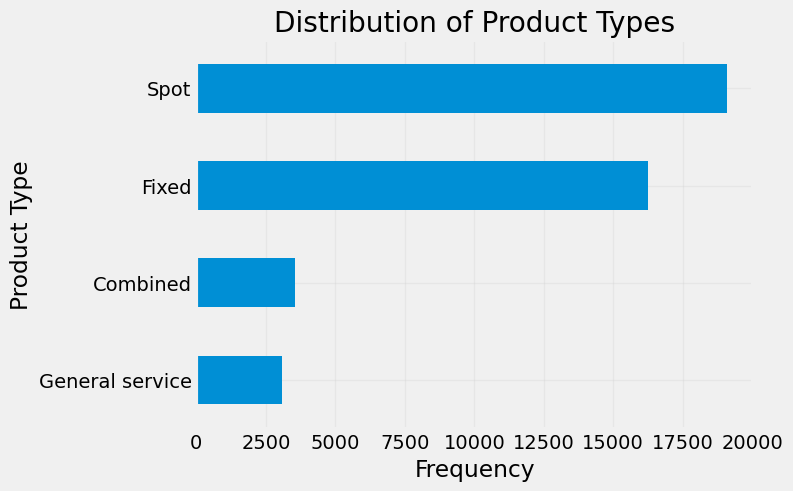

In [24]:
fig, ax = plt.subplots()
enefit_dict['client'].product_type_map.value_counts().plot(
    kind='barh', xlabel='Frequency', 
    ylabel='Product Type',
    title='Distribution of Product Types',
    ax=ax
).invert_yaxis()
ax.grid(alpha=.25)
plt.show()

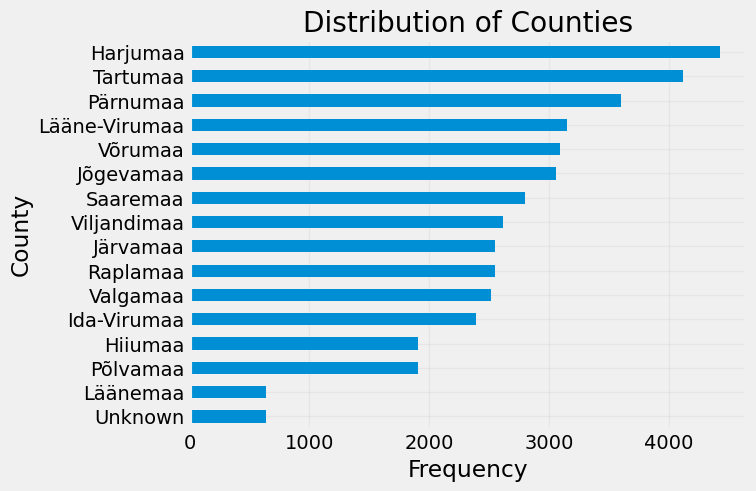

In [25]:
fig, ax = plt.subplots()
enefit_dict['client'].county_map.value_counts().plot(
    kind='barh', xlabel='Frequency',
    ylabel='County',
    title='Distribution of Counties',
    ax=ax
).invert_yaxis()
ax.grid(alpha=.25)
plt.show()

Harjumaa county has the highest total installed capacity.

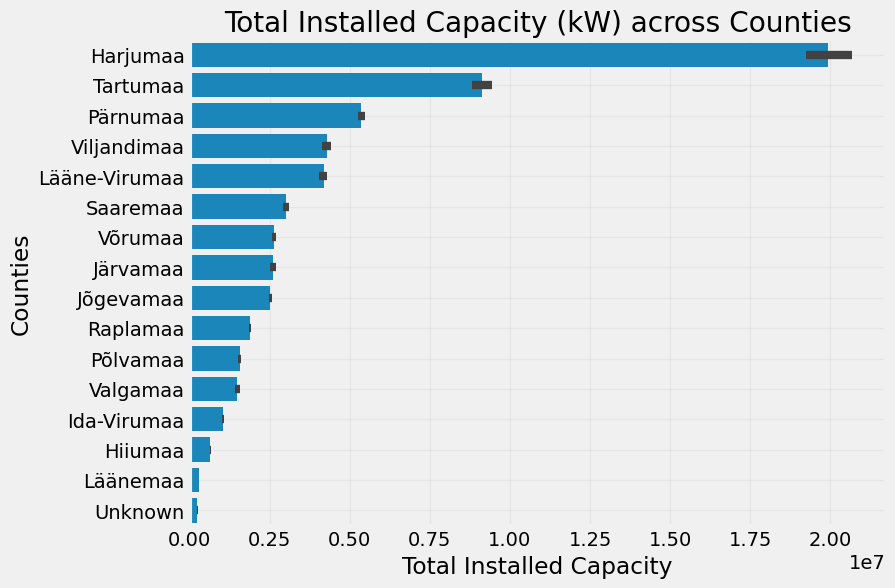

In [26]:
plot_order = enefit_dict['client'].groupby(by='county_map').agg({'installed_capacity':'sum'}).sort_values(by='installed_capacity', ascending=False).index.values

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(
    data=enefit_dict['client'],
    x='installed_capacity',
    y='county_map',
    estimator='sum',
    orient='h',
    order=plot_order,
    ax=ax
)
ax.grid(alpha=.25)

ax.set_xlabel('Total Installed Capacity')
ax.set_ylabel('Counties')
ax.set_title('Total Installed Capacity (kW) across Counties')

plt.show()

For most counties, installed capacity for businesses is higher than capacity for non-businesses.

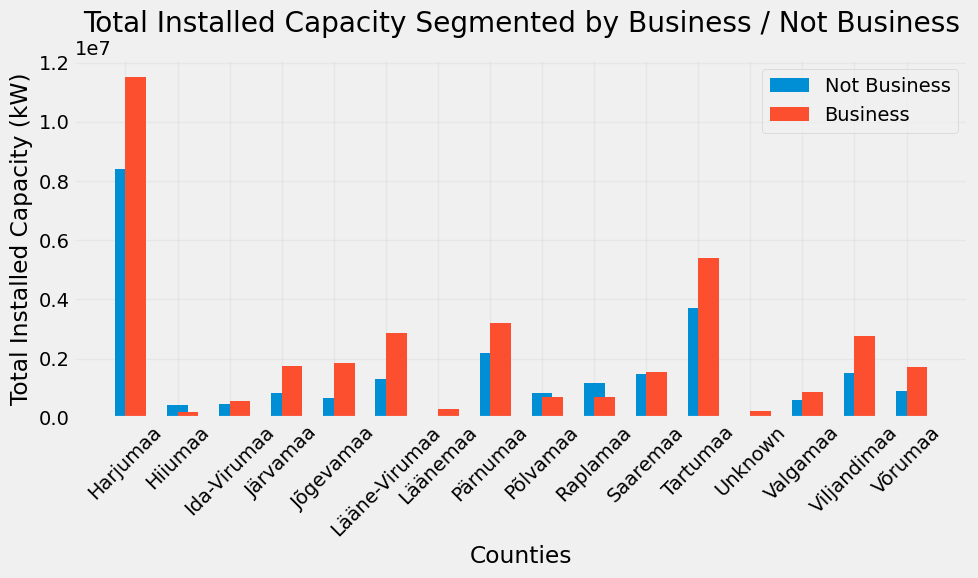

In [27]:
df = enefit_dict['client'].groupby(by=['county_map', 'is_business']).installed_capacity.sum().unstack().rename(columns={0:'not_business', 1:'business'})

plt.figure(figsize=(10, 6))
plt.bar(df.index, df.not_business, width=0.4, align='center', label='Not Business')
plt.bar(df.index, df.business, width=0.4, align='edge', label='Business')

plt.xlabel('Counties')
plt.ylabel('Total Installed Capacity (kW)')
plt.title('Total Installed Capacity Segmented by Business / Not Business')
plt.legend()
plt.xticks(rotation=45)
plt.grid(alpha=.25)
plt.tight_layout()
plt.show()


Most activity is in the spot market, where business clients are more popular. The second most popular market is the fixed market, where non-business clients dominate. There is nearly no activity in the general service market and the combined market services only business consumers.

Developing a model to reduce energy imbalance costs will have to prioritize the spot and fixed markets, which make up nearly all products sold.

<Figure size 1000x800 with 0 Axes>

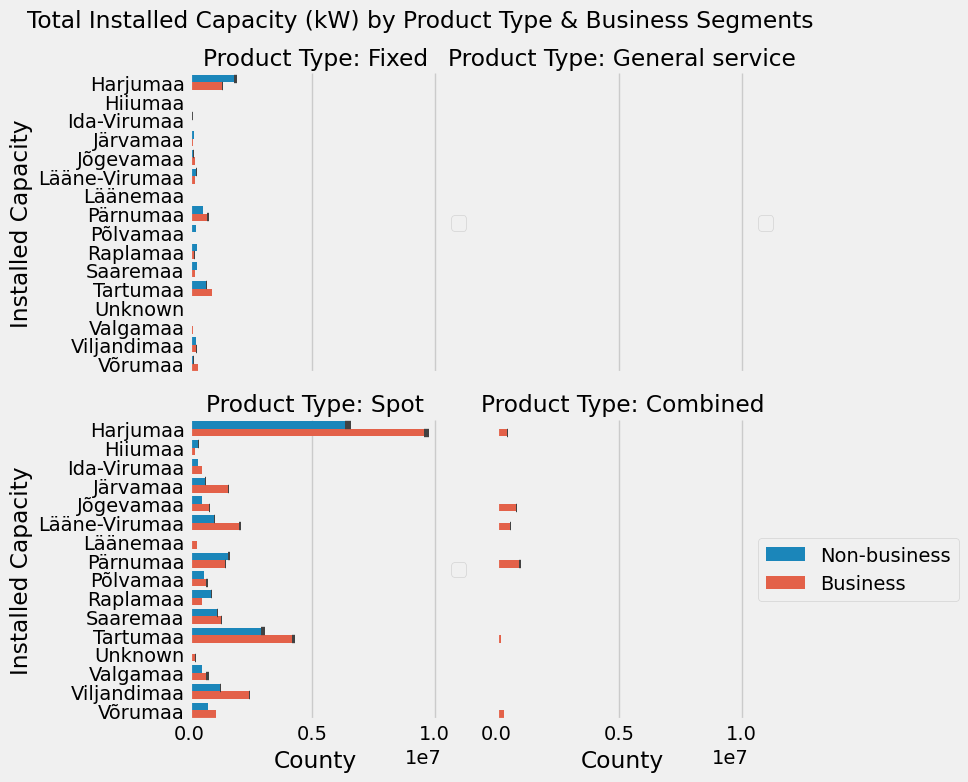

In [28]:
plt.figure(figsize=(10, 8))
g = sns.catplot(
    data=enefit_dict['client'],
    kind="bar",
    orient='h',
    y='county_map',
    x='installed_capacity',
    hue='is_business',
    col='product_type_map',
    col_wrap=2,
    height=4,
    estimator=sum
)

g.set_axis_labels('County', 'Installed Capacity')
g.set_titles('Product Type: {col_name}')

new_labels = ['Non-business', 'Business']
for ax in g.axes.flat:
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles, new_labels, loc='center left', bbox_to_anchor=(1, 0.5))

# Remove the previous legend
g._legend.remove()

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Total Installed Capacity (kW) by Product Type & Business Segments')

plt.show()


Let's drill down to general service to see it clearer:

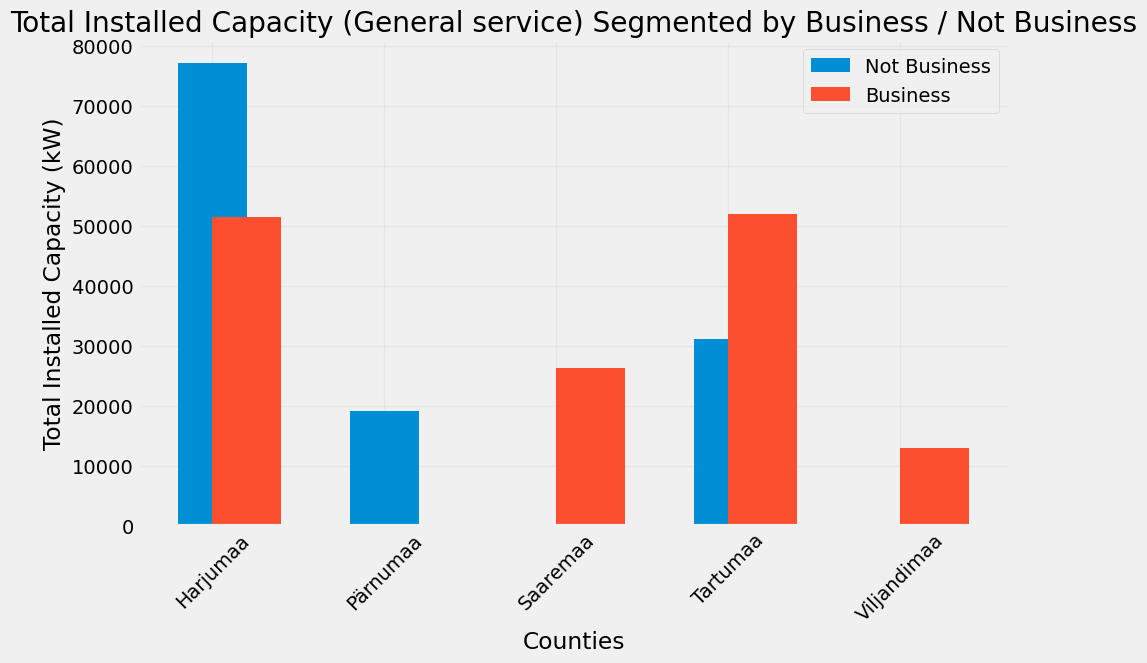

In [29]:
df = enefit_dict['client'].query(
    'product_type_map=="General service"'
).groupby(by=['county_map', 'is_business']).installed_capacity.sum().unstack().rename(columns={0:'not_business', 1:'business'})

plt.figure(figsize=(10, 6))
plt.bar(df.index, df.not_business, width=0.4, align='center', label='Not Business')
plt.bar(df.index, df.business, width=0.4, align='edge', label='Business')

plt.xlabel('Counties')
plt.ylabel('Total Installed Capacity (kW)')
plt.title('Total Installed Capacity (General service) Segmented by Business / Not Business')
plt.legend()
plt.xticks(rotation=45)
plt.grid(alpha=.25)
plt.show()


Let's drill down to combined to see it clearer:

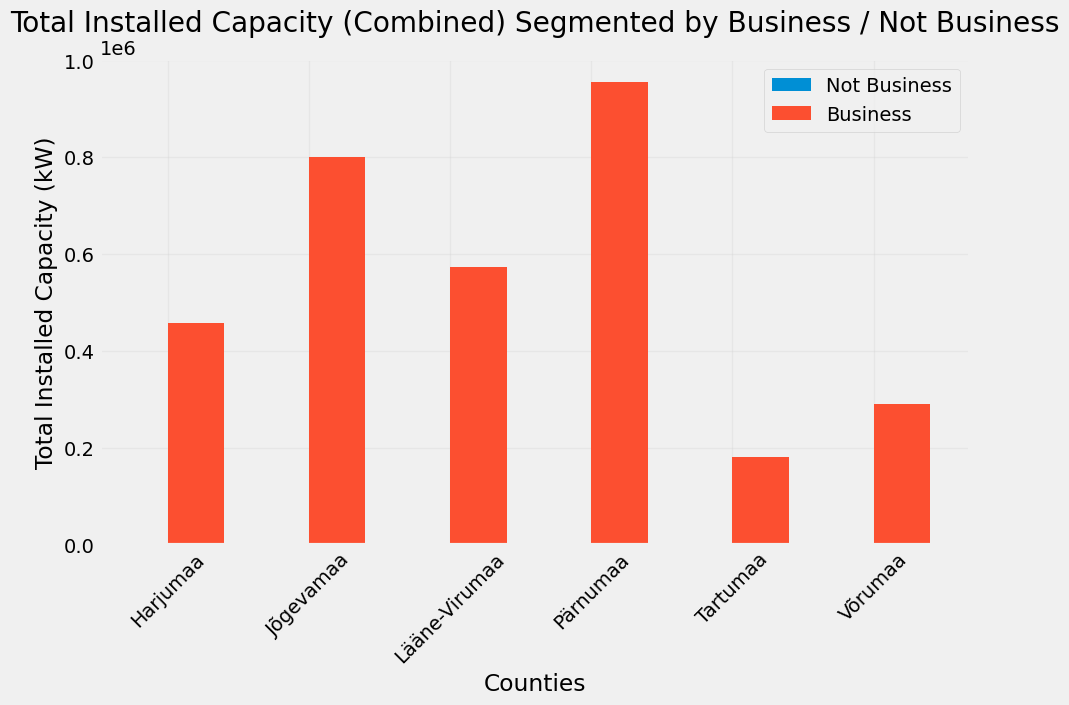

In [30]:
df = enefit_dict['client'].query(
    'product_type_map=="Combined"'
).groupby(by=['county_map', 'is_business']).installed_capacity.sum().unstack().rename(columns={0:'not_business', 1:'business'})
df['not_business'] = 0

plt.figure(figsize=(10, 6))
plt.bar(df.index, df.not_business, width=0.4, align='center', label='Not Business')
plt.bar(df.index, df.business, width=0.4, align='edge', label='Business')

plt.xlabel('Counties')
plt.ylabel('Total Installed Capacity (kW)')
plt.title('Total Installed Capacity (Combined) Segmented by Business / Not Business')
plt.legend()
plt.xticks(rotation=45)
plt.grid(alpha=.25)
plt.show()


In [31]:
# Calculate the absolute increase
ic_mom = enefit_dict['client']['installed_capacity'].diff()

# Calculate the average increase
average_increase = ic_mom.mean()

print(f"Average month-on-month increase in Installed Capacity: {average_increase:.2f}kW")

Average month-on-month increase in Installed Capacity: 0.03kW


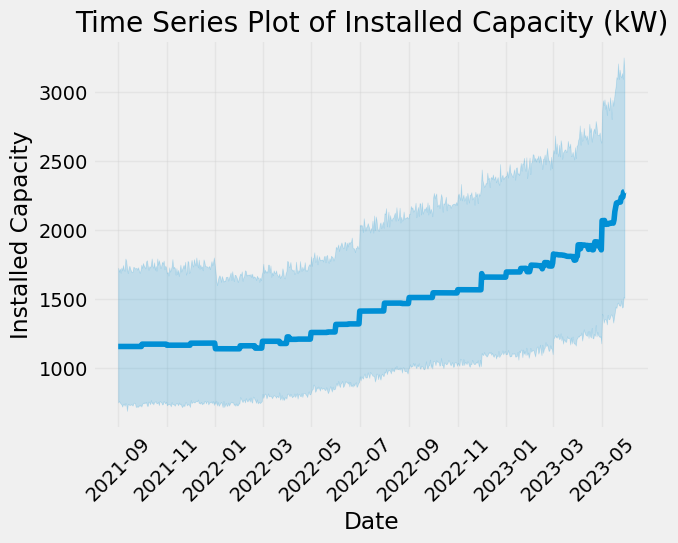

In [32]:
sns.lineplot(
    x='date', y='installed_capacity', data=enefit_dict['client']
)
plt.xlabel('Date')
plt.ylabel('Installed Capacity')
plt.title('Time Series Plot of Installed Capacity (kW)')
plt.xticks(rotation=45)
plt.grid(alpha=.3)
plt.show()

In [33]:
# Calculate the absolute increase
eic_mom = enefit_dict['client']['eic_count'].diff()

# Calculate the average increase
average_increase = eic_mom.mean()

print(f"Average month-on-month increase in Consumption Points: {average_increase:.4f}")

Average month-on-month increase in Consumption Points: -0.0013


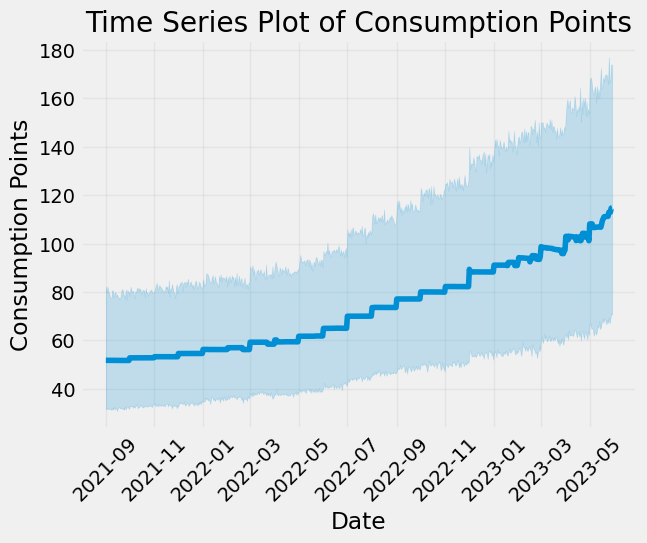

In [34]:
sns.lineplot(
    x='date', y='eic_count', data=enefit_dict['client']
)
plt.xlabel('Date')
plt.ylabel('Consumption Points')
plt.title('Time Series Plot of Consumption Points')
plt.xticks(rotation=45)
plt.grid(alpha=.3)
plt.show()

**Electricity Prices**

The features in this dataset are:
* origin_date: The date when the day-ahead prices became available.
* forecast_date: The date when the forecast prices should be relevant.
* euros_per_mwh: The price of electricity on the day ahead markets in euros per megawatt hour.
* data_block_id: All rows sharing the same `data_block_id` will be available at the same forecast time. This is a function of what information is available when forecasts are actually made, at 11 AM each morning. For example, if the forecast weather `data_block_id` for predictions made on October 31st is 100 then the historic weather data_block_id for October 31st will be 101 as the historic weather data is only actually available the next day.

In [35]:
enefit_dict['electricity_prices'].head()

,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1


In [36]:
enefit_dict['electricity_prices'].describe()

,forecast_date,euros_per_mwh,origin_date,data_block_id
count,15286,15286.000000,15286,15286.000000
mean,2022-07-16 11:16:41.857909248,157.064176,2022-07-15 11:16:41.857909248,318.990710
min,2021-09-01 00:00:00,-10.060000,2021-08-31 00:00:00,1.000000
25%,2022-02-07 05:15:00,85.290000,2022-02-06 05:15:00,160.000000
50%,2022-07-16 11:30:00,128.280000,2022-07-15 11:30:00,319.000000
75%,2022-12-22 16:45:00,199.797500,2022-12-21 16:45:00,478.000000
max,2023-05-30 23:00:00,4000.000000,2023-05-29 23:00:00,637.000000
std,NaN,121.148625,NaN,183.890301


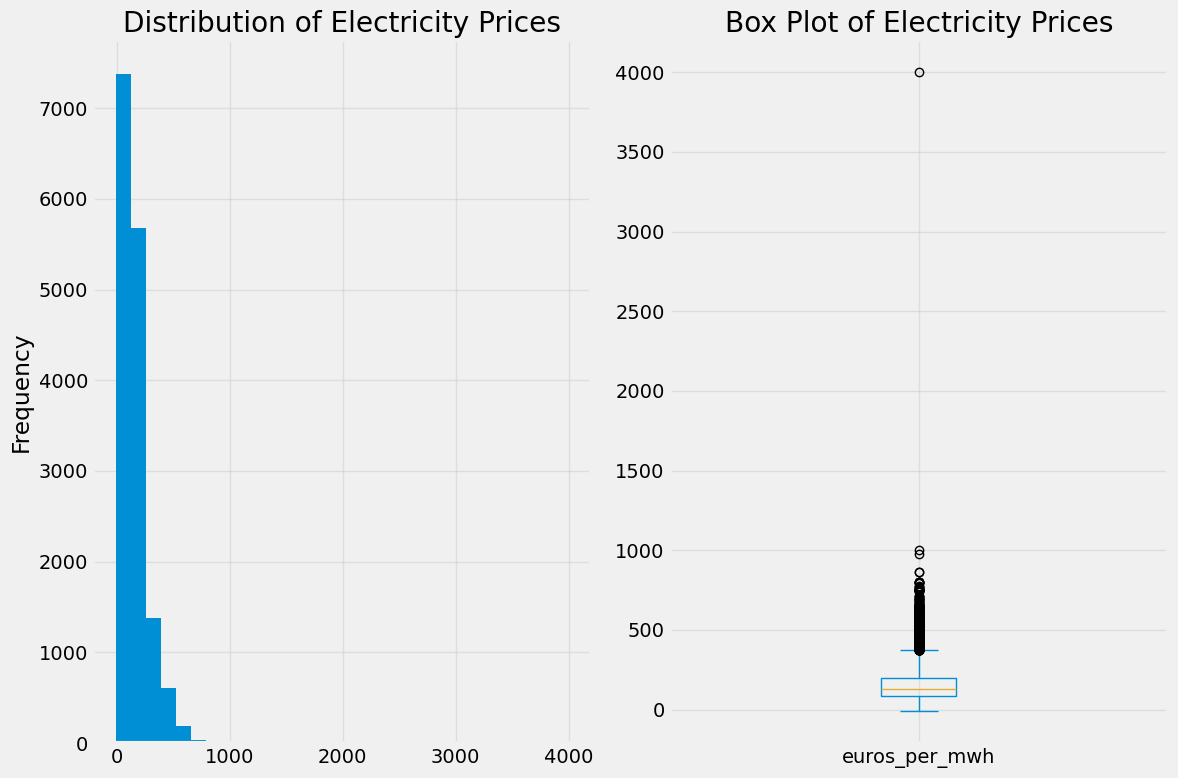

In [37]:
plt.figure(figsize=(12, 8))
plt.subplot(121)
enefit_dict['electricity_prices'].euros_per_mwh.plot.hist(
    bins=30, 
    title='Distribution of Electricity Prices',
)
plt.grid(alpha=.5)

plt.subplot(122)
enefit_dict['electricity_prices'].euros_per_mwh.plot.box(title='Box Plot of Electricity Prices')
plt.grid(alpha=.5)

plt.tight_layout()
plt.show()

25% of the dataset is greater than the 75th percentile:

In [38]:
enefit_dict['electricity_prices'].query('euros_per_mwh > 200').shape[0] / enefit_dict['electricity_prices'].shape[0]

0.24525709799816825

There's a single large outlier record. It is for `data_block_id` 351:

In [39]:
enefit_dict['electricity_prices'].query('euros_per_mwh > 2000')

,forecast_date,euros_per_mwh,origin_date,data_block_id
8416,2022-08-17 17:00:00,4000.0,2022-08-16 17:00:00,351


In [40]:
avg_cost_full = enefit_dict['electricity_prices'].query('data_block_id==351').euros_per_mwh.mean()
avg_cost_filtered = enefit_dict['electricity_prices'].query('data_block_id==351 & euros_per_mwh < 2000').euros_per_mwh.mean()
euro_symbol = '\u20AC'

print(f'The average electricity cost for data block id number 351 is {euro_symbol}{avg_cost_full:,.2f}, while the average cost without the outlier record is {euro_symbol}{avg_cost_filtered:,.2f}.')

The average electricity cost for data block id number 351 is €682.05, while the average cost without the outlier record is €537.79.


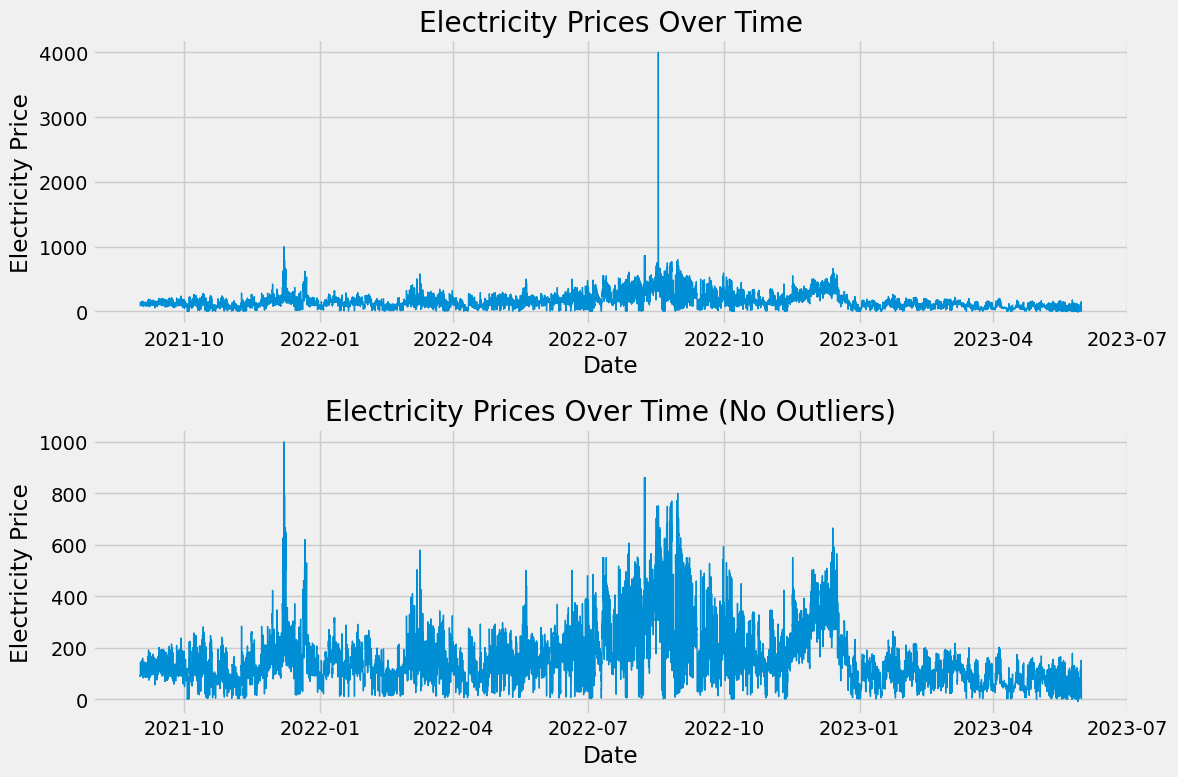

In [41]:
plt.figure(figsize=(12, 8))

plt.subplot(211)
plt.plot(
    enefit_dict['electricity_prices'].forecast_date,
    enefit_dict['electricity_prices'].euros_per_mwh, 
    linestyle='-', linewidth=1
)
plt.xlabel('Date')
plt.ylabel('Electricity Price')
plt.title('Electricity Prices Over Time')

plt.subplot(212)
plt.plot(
    enefit_dict['electricity_prices'].query('euros_per_mwh < 2000').forecast_date,
    enefit_dict['electricity_prices'].query('euros_per_mwh < 2000').euros_per_mwh,
    linestyle='-', linewidth=1
)
plt.xlabel('Date')
plt.ylabel('Electricity Price')
plt.title('Electricity Prices Over Time (No Outliers)')

plt.tight_layout()
plt.show()

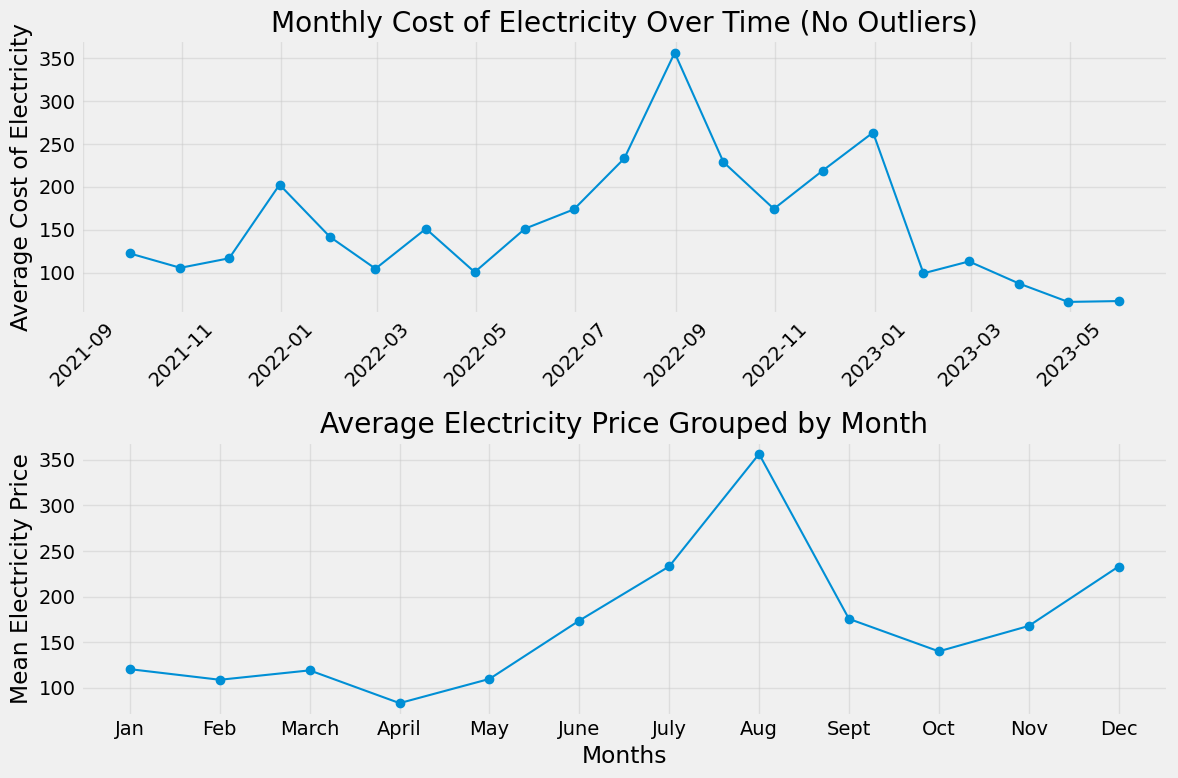

Electricity Costs are on average highest in the summer, with the peak occurring in the summer of 2022


In [42]:
monthly_mean = enefit_dict['electricity_prices'].query('euros_per_mwh < 2000').set_index('forecast_date').euros_per_mwh.resample('M').mean().interpolate()

plt.figure(figsize=(12, 8))
plt.subplot(211)
plt.plot(
    monthly_mean.index, monthly_mean, marker='o', linestyle='-', linewidth=1.5
)
plt.xticks(rotation=45)
plt.ylabel('Average Cost of Electricity')
plt.title('Monthly Cost of Electricity Over Time (No Outliers)')
plt.grid(alpha=.5)

plt.subplot(212)
monthly_mean = enefit_dict['electricity_prices'].query('euros_per_mwh < 2000').euros_per_mwh.groupby(enefit_dict['electricity_prices'].forecast_date.dt.month).mean()

month_mapping = {
    1: 'Jan', 2: 'Feb', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'Aug',
    9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
monthly_mean.index = monthly_mean.index.map(month_mapping)
plt.plot(
    monthly_mean.index, monthly_mean, marker='o', linestyle='-', linewidth=1.5
)
plt.xlabel('Months')
plt.ylabel('Mean Electricity Price')
plt.title('Average Electricity Price Grouped by Month')
plt.grid(alpha=.5)

plt.tight_layout()
plt.show()

print('Electricity Costs are on average highest in the summer, with the peak occurring in the summer of 2022')

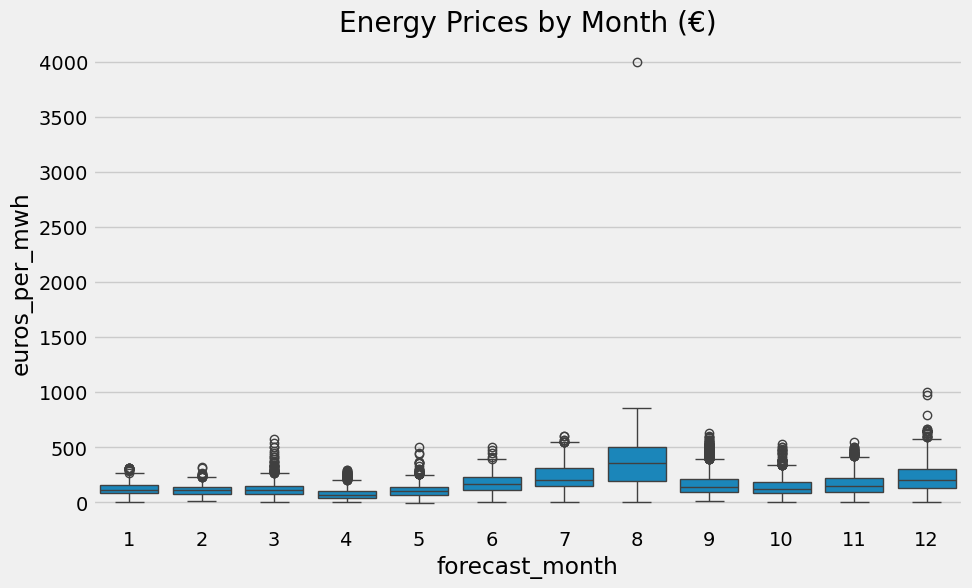

In [43]:
enefit_dict['electricity_prices']['forecast_month'] = enefit_dict['electricity_prices'].forecast_date.dt.month

plt.figure(figsize=(10, 6))
sns.boxplot(
    x='forecast_month', y='euros_per_mwh', data=enefit_dict['electricity_prices']
)
# plt.grid(alpha=.5)
plt.title('Energy Prices by Month (€)')
plt.show()

In [44]:
# Calculate the absolute increase
cost_mom = enefit_dict['electricity_prices']['euros_per_mwh'].diff()

# Calculate the average increase
average_increase = cost_mom.mean()

print(f"Average month-on-month increase in Electricity Cost: {average_increase:.4f} Euros")

Average month-on-month increase in Electricity Cost: -0.0061 Euros


The cost of electricity is generally in the same range except for a significant spike in August 2022.

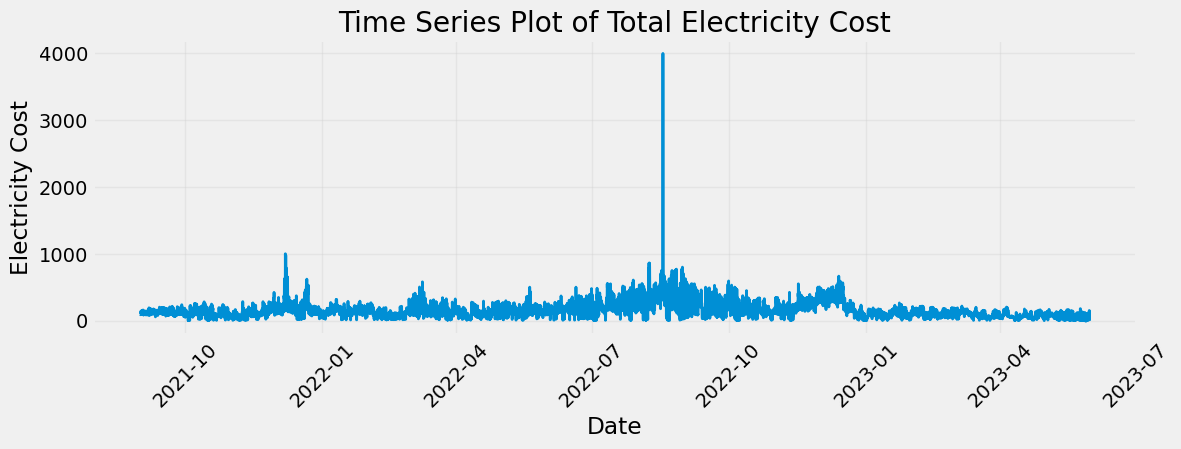

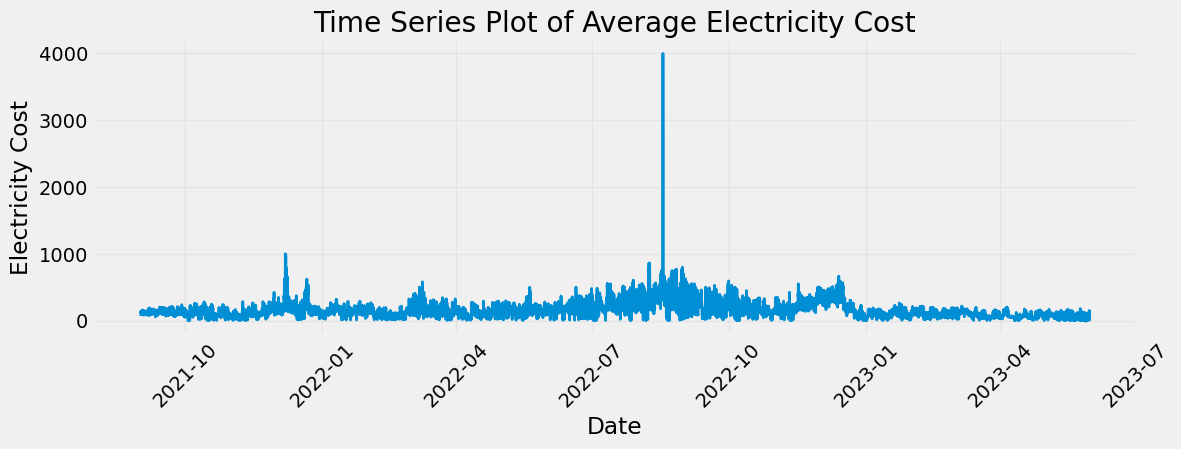

In [45]:
plt.figure(figsize=(12, 8))
plt.subplot(211)
sns.lineplot(
    x='forecast_date', y='euros_per_mwh', data=enefit_dict['electricity_prices'],
    estimator='sum', size=.7
)
plt.xlabel('Date')
plt.ylabel('Electricity Cost')
plt.title('Time Series Plot of Total Electricity Cost')
plt.xticks(rotation=45)
plt.grid(alpha=.3)
plt.legend().remove()


plt.figure(figsize=(12, 8))
plt.subplot(211)
sns.lineplot(
    x='forecast_date', y='euros_per_mwh', 
    data=enefit_dict['electricity_prices'],
    estimator='mean', size=.7
)
plt.xlabel('Date')
plt.ylabel('Electricity Cost')
plt.title('Time Series Plot of Average Electricity Cost')
plt.xticks(rotation=45)
plt.grid(alpha=.3)
plt.legend().remove()

plt.show()

Time Series Plot without Outlier record:

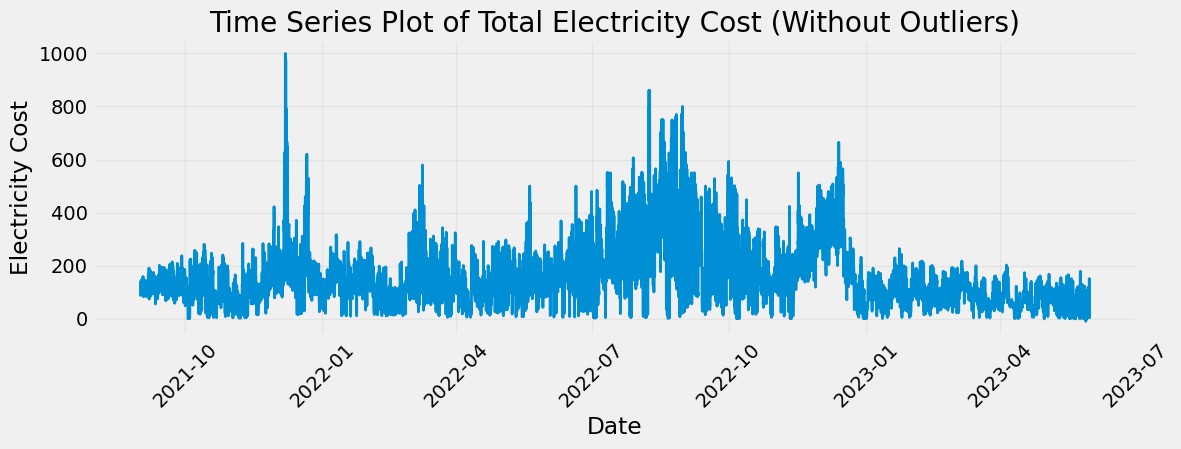

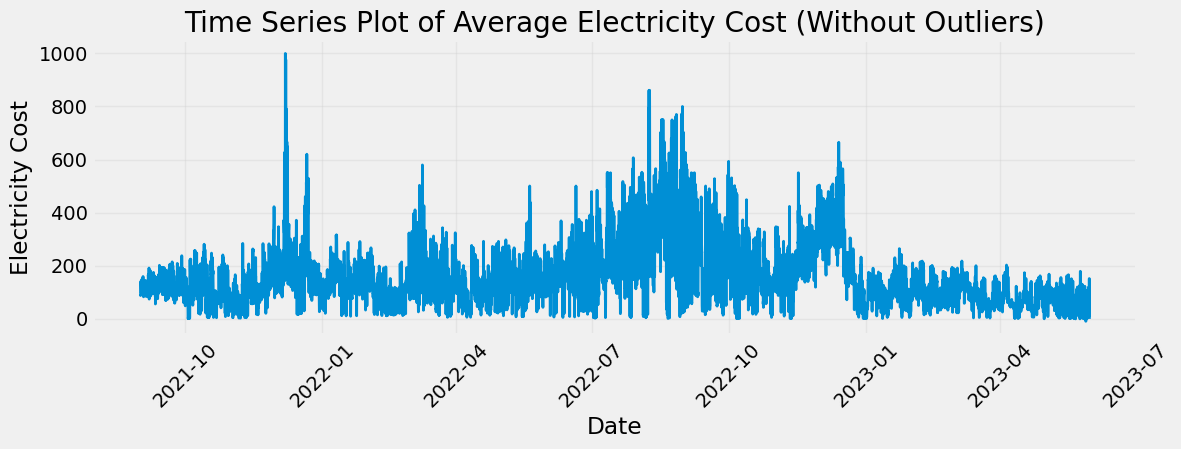

In [46]:
plt.figure(figsize=(12, 8))
plt.subplot(211)
sns.lineplot(
    x='forecast_date', y='euros_per_mwh', data=enefit_dict['electricity_prices'].query('euros_per_mwh < 2000'),
    estimator='sum', size=.7
)
plt.xlabel('Date')
plt.ylabel('Electricity Cost')
plt.title('Time Series Plot of Total Electricity Cost (Without Outliers)')
plt.xticks(rotation=45)
plt.grid(alpha=.3)
plt.legend().remove()


plt.figure(figsize=(12, 8))
plt.subplot(211)
sns.lineplot(
    x='forecast_date', y='euros_per_mwh',
    data=enefit_dict['electricity_prices'].query('euros_per_mwh < 2000'),
    estimator='mean', size=.7
)
plt.xlabel('Date')
plt.ylabel('Electricity Cost')
plt.title('Time Series Plot of Average Electricity Cost (Without Outliers)')
plt.xticks(rotation=45)
plt.grid(alpha=.3)
plt.legend().remove()

plt.show()

Time Series Decomposition:

Decompose the time series into its trend, seasonality, and residual components to better understand underlying patterns.

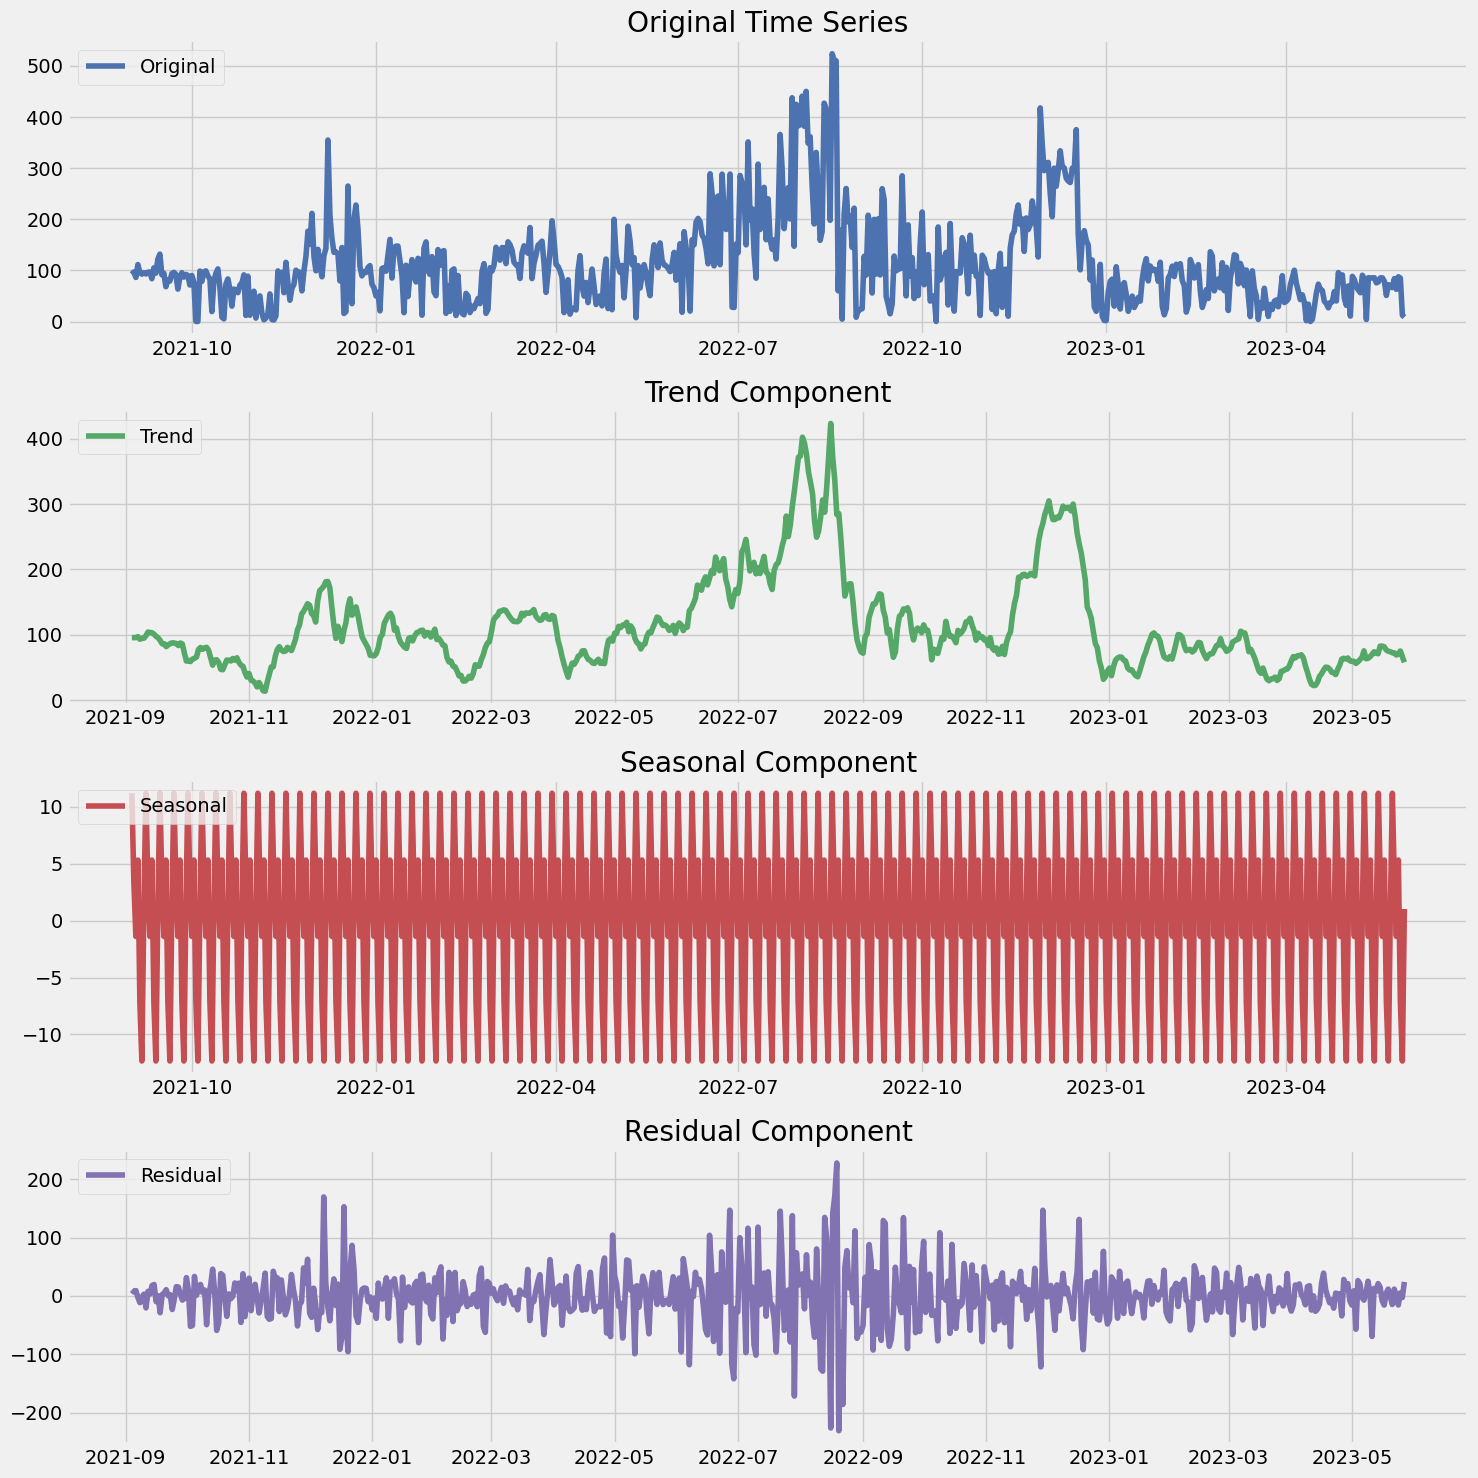

In [47]:
data = enefit_dict['electricity_prices'].set_index('forecast_date').euros_per_mwh.asfreq('D').bfill()

decomposition = seasonal_decompose(data, model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the original time series
plt.figure(figsize=(15, 15))
plt.subplot(411)
plt.plot(data, label='Original', color=deep_colors[0])
plt.legend(loc='upper left')
plt.title('Original Time Series')

# Plot the trend component
plt.subplot(412)
plt.plot(trend, label='Trend', color=deep_colors[1])
plt.legend(loc='upper left')
plt.title('Trend Component')

# Plot the seasonal component
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color=deep_colors[2])
plt.legend(loc='upper left')
plt.title('Seasonal Component')

# Plot the residual component
plt.subplot(414)
plt.plot(residual, label='Residual', color=deep_colors[3])
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()

Analyzing Trend Component:

There are erratic movements in the trend which might suggest volatility, however, the trendline is flat, indicating that there is no overall trend or movement in the price of electricity. Prices remain constant with no discernible change or variation over the observed time period:

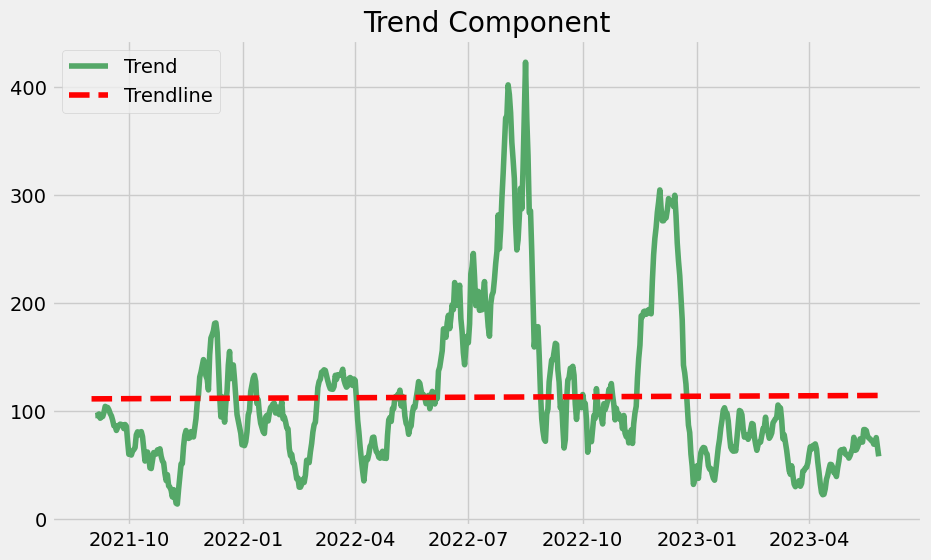

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(trend, label='Trend', color=deep_colors[1])

# Fit a linear regression trend-line
x_values = pd.to_numeric(trend.index) / 10**9
coefficients = np.polyfit(x_values, trend.fillna(0), 1)
slope, intercept = coefficients
trendline_values = slope * x_values + intercept
trendline_dates = pd.to_datetime(x_values.astype(int) * 10**9)

plt.plot(trendline_dates, trendline_values, label='Trendline', linestyle='--', color='red')
plt.legend(loc='upper left')
plt.title('Trend Component')

plt.show()

Analyzing Seasonal Component:

When we drill down into the seasonal component, we find repetitive and predictitve patterns occurring at fixed intervals within the data. Seasonality represents the systematic, periodic fluctuations that repeat over specific time periods (e.g., daily, weekly, monthly, yearly).

For electricty prices, we have repetitive weekly fluctuations throughout the data:

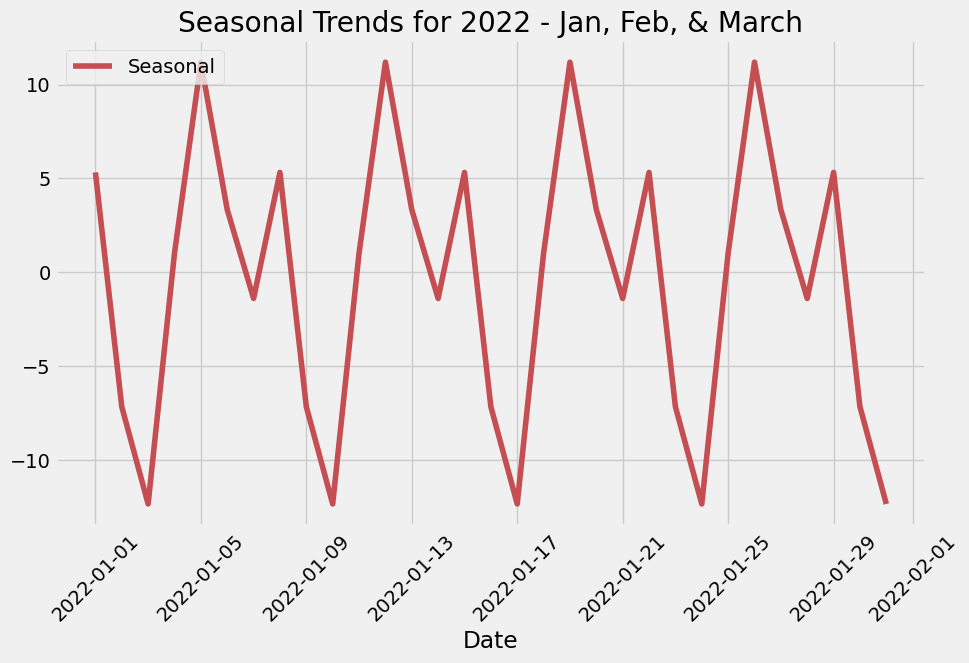

In [49]:
year = 2022
months_to_select = [1]  

selected_data = seasonal[(seasonal.index.year == year) & (seasonal.index.month.isin(months_to_select))]

plt.figure(figsize=(10, 6))
plt.plot(selected_data, label='Seasonal', color=deep_colors[2])
plt.xlabel('Date')
plt.title(f'Seasonal Trends for {year} - Jan, Feb, & March')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.show()

Assessing the amplitude or magnitude of the seasonal fluctuations:

The range and standard deviation of the seasonal component are not as high, indicating that the amplitude are not as high and there is not significant variability fo data points from the mean.

However, the Coefficient of variation is significantly large indicating that the mean of seasonality is small relative to the variability or dispersion of the data points (or the spread or variability among the data points is large relative to that mean).

In [50]:
# Assessing amplitude using statistical measures
seasonal_amplitude = seasonal.max() - seasonal.min()
std_dev = seasonal.std()
coefficient_of_variation = std_dev / seasonal.mean()
amplitude_mean = seasonal.mean()
amplitude_median = seasonal.median()
amplitude_variance = seasonal.var()
amplitude_percentile_95 = np.percentile(seasonal, 95)
amplitude_percentile_5 = np.percentile(seasonal, 5)

print(f"Amplitude (Range) of Seasonal Component: {seasonal_amplitude:.2f}")
print(f"Mean of Seasonal Component: {amplitude_mean}")
print(f"Median of Seasonal Component: {amplitude_median:.2f}")
print(f"Variance of Seasonal Component: {amplitude_variance:.2f}")
print(f"Standard Deviation of Seasonal Component: {std_dev:.2f}")
print(f"Coefficient of Variation of Seasonal Component: {coefficient_of_variation:.4f}")
print(f"95th Percentile of Seasonal Component: {amplitude_percentile_95:.2f}")
print(f"5th Percentile of Seasonal Component: {amplitude_percentile_5:.2f}")

Amplitude (Range) of Seasonal Component: 23.52
Mean of Seasonal Component: 3.067492187347371e-16
Median of Seasonal Component: 1.02
Variance of Seasonal Component: 53.05
Standard Deviation of Seasonal Component: 7.28
Coefficient of Variation of Seasonal Component: 23744962897672952.0000
95th Percentile of Seasonal Component: 11.19
5th Percentile of Seasonal Component: -12.33


Compare the amplitude of seasonal fluctuations across different time periods or seasonal cycles:

We used 7-day periods and 30-day periods. We observed a constant coefficient of variation (CV) for a 7-day period and an array of seven values for a 30-day period. This might indicate that the 7-day period is consistently exhibiting the same level of relative variability (CV) (_confirming our visualization above_), while the 30-day period is providing multiple CV values because of the different cycles or segments within that period.

The 7-day period consistently captures a specific part of the seasonal pattern, leading to a constant CV across those shorter segments. However, the 30-day period encompasses different parts of the seasonal variation, resulting in variable CV values when analyzing each 30-day segment.

This information will be relevant for forecasting.

In [51]:
result = seasonal_decompose(data, model='additive') 

period = 30
num_cycles = len(data) // period
seasonal_amplitudes = []
for i in range(num_cycles):
    start_idx = i * period
    end_idx = min((i + 1) * period, len(data))
    seasonal_component = result.seasonal[start_idx:end_idx]
    amplitude = seasonal_component.max() - seasonal_component.min()
    cv = (seasonal_component.std() / seasonal_component.mean()) * 100
    seasonal_amplitudes.append({'Period': i + 1, 'Amplitude': amplitude, 'CV_30': cv})
amplitudes_df_30 = pd.DataFrame(seasonal_amplitudes)

period = 7
num_cycles = len(data) // period
seasonal_amplitudes = []
for i in range(num_cycles):
    start_idx = i * period
    end_idx = min((i + 1) * period, len(data))
    seasonal_component = result.seasonal[start_idx:end_idx]
    amplitude = seasonal_component.max() - seasonal_component.min()
    cv = (seasonal_component.std() / seasonal_component.mean()) * 100
    seasonal_amplitudes.append({'Period': i + 1, 'Amplitude': amplitude, 'CV_7': cv})
amplitudes_df_7 = pd.DataFrame(seasonal_amplitudes)

amplitudes_df = amplitudes_df_7.merge(amplitudes_df_30, how='left', on=['Period', 'Amplitude'])
amplitudes_df.head(7)

,Period,Amplitude,CV_7,CV_30
0,1,23.518254,2.478249e+19,1539.726343
1,2,23.518254,2.478249e+19,5513.461624
2,3,23.518254,2.478249e+19,-1169.904195
3,4,23.518254,2.478249e+19,1827.323086
4,5,23.518254,2.478249e+19,11057.166093
5,6,23.518254,2.478249e+19,-12023.922850
6,7,23.518254,2.478249e+19,-1990.369643


Analyzing Residual Component:

Analyzing the residual component resulting from a seasonal decomposition helps to understand the unexplained variation in the time series after accounting for the trend, seasonality, and other identified components. It is crucial to assess the goodness-of-fit of the decomposition model and to detect any remaining patterns or information that the model didn't capture.

The distribution of the residual plot appears to be approximately normal and the autocorrelation plot shows a flat line with no significant spikes. This indicates that residuals are centered and have consistent variability. 

The flat autocorrelation also indicates the absence of significant autocorrelation at different lags, which suggests that the residuals are not correlated at different time lags, indicating randomness or lack of systematic patterns.

The normal distribution and absence of significant autocorrelation in residuals suggest that the seasonal decomposition model adequately captures the underlying trend, seasonality, and other components present in the time series data for electricty prices. This implies goodness of fit and model adequacy.

The lack of autocorrelation further implies that any remaining variation in the data captured by the residuals is random noise or unexplained variability, rather than systematic patterns or trends.

We can therefore use the decomposition model to forecast future observation as the model adequately captures the data's variability.

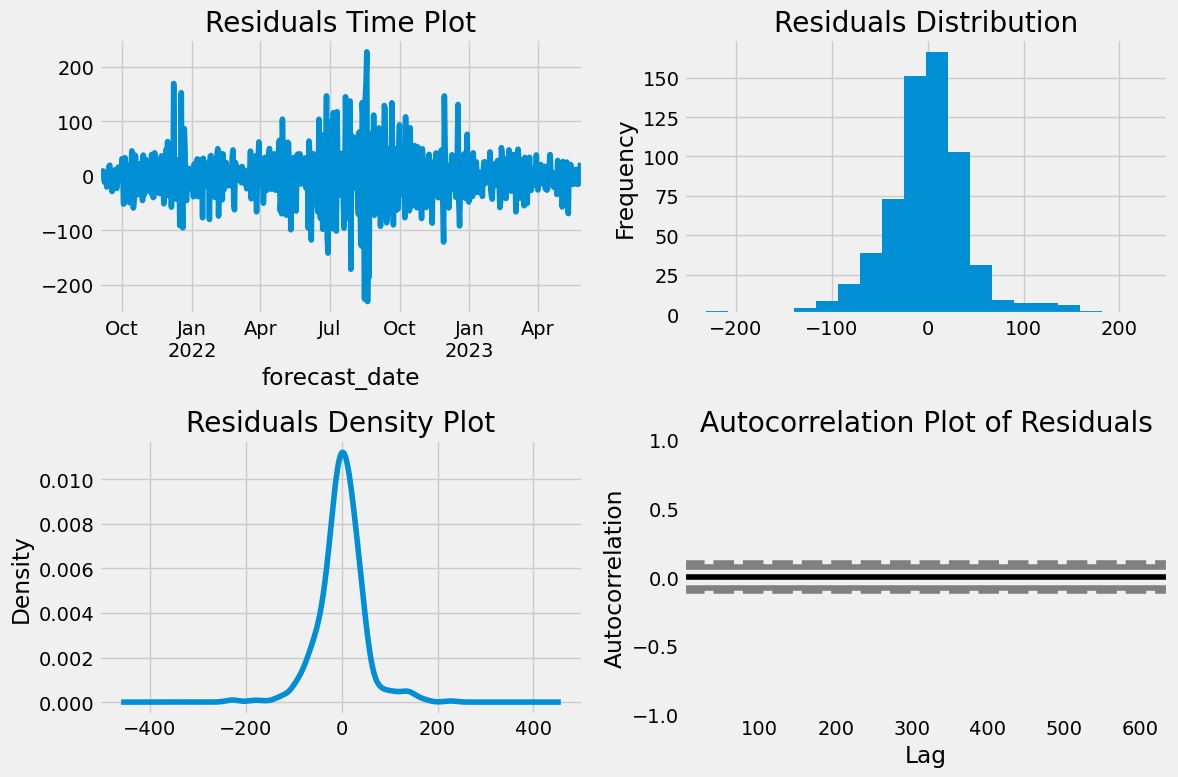

In [52]:
# Visualize residuals
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
residual.plot(title='Residuals Time Plot')

plt.subplot(2, 2, 2)
residual.plot(kind='hist', bins=20, title='Residuals Distribution')

plt.subplot(2, 2, 3)
residual.plot(kind='kde', title='Residuals Density Plot')

plt.subplot(2, 2, 4)
pd.plotting.autocorrelation_plot(residual)
plt.title('Autocorrelation Plot of Residuals')

plt.tight_layout()
plt.show()

In [53]:
# Statistical Analysis
print("Summary Statistics of Residuals:")
print(residual.describe())

Summary Statistics of Residuals:
count    631.000000
mean       0.049807
std       47.220200
min     -230.776190
25%      -22.496511
50%        0.819426
75%       22.566243
max      227.663267
Name: resid, dtype: float64


All Periods apart from the 1st, have high test statistics indicating the presence of autocorrelation, which suggests that the residuals are not independently distributed. 

In [54]:
# Perform Ljung-Box test for serial correlation
ljungbox_df = acorr_ljungbox(residual.dropna(), lags=10)
ljungbox_df

,lb_stat,lb_pvalue
1,3.288330,6.977395e-02
2,39.685669,2.411940e-09
3,94.359418,2.534994e-20
4,94.685115,1.329591e-19
5,97.941829,1.434520e-19
6,98.200819,5.953724e-19
7,100.197515,9.820859e-19
8,102.311888,1.437146e-18
9,110.360176,1.241935e-19
10,115.738668,3.696421e-20


In [55]:
data = data.reset_index()
data['numeric_date'] = pd.to_numeric(data.index)
X = data.numeric_date
y = data.euros_per_mwh

# Add a constant to the independent variable (for intercept)
X = sm.add_constant(X)
# Fit the regression model
model = sm.OLS(y, X).fit()
# Print model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          euros_per_mwh   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.01993
Date:                Thu, 23 Nov 2023   Prob (F-statistic):              0.888
Time:                        12:00:29   Log-Likelihood:                -3749.3
No. Observations:                 637   AIC:                             7503.
Df Residuals:                     635   BIC:                             7511.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          112.7322      6.904     16.330   

Time Series Modeling:

In [56]:
# Define the ARIMA model (p=order of autoregression, d=differencing, q=order of moving average)
data = data.set_index('forecast_date')
data = data.asfreq('D').bfill()
# Example order (p, d, q)
model = ARIMA(data['euros_per_mwh'], order=(1, 1, 1))  

# Fit the ARIMA model
arima_model = model.fit()

# Predict future prices (example: predicting next 10 steps)
# Change the number of steps as needed
forecast = arima_model.forecast(steps=10)  
print(forecast)

2023-05-31    41.701984
2023-06-01    47.428105
2023-06-02    48.417736
2023-06-03    48.588772
2023-06-04    48.618332
2023-06-05    48.623440
2023-06-06    48.624323
2023-06-07    48.624476
2023-06-08    48.624502
2023-06-09    48.624507
Freq: D, Name: predicted_mean, dtype: float64


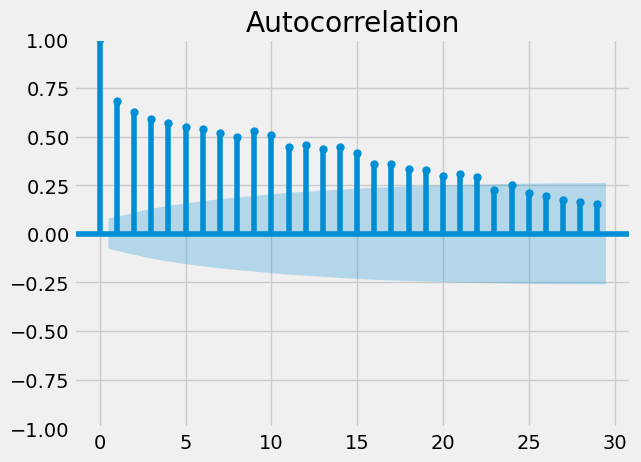

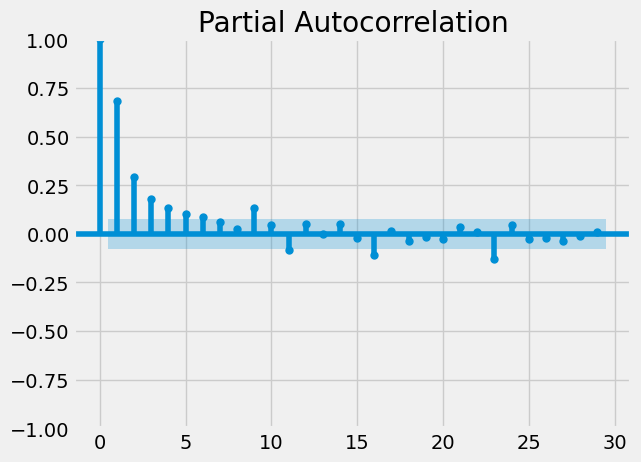

In [57]:
# Plot ACF and PACF
data = data.drop(columns='numeric_date')

plot_acf(data)
plot_pacf(data)
plt.show()


In [62]:
# Calculate ACF and PACF values
acf_values = acf(data)
pacf_values = pacf(data)

# Define p, d, q ranges
p_range = range(0, 10)
d_range = range(0, 10)
q_range = range(0, 10)

# Generate combinations of p, d, q values
parameter_combinations = list(itertools.product(p_range, d_range, q_range))

best_aic = float("inf")
best_params = None

# Iterate through parameter combinations
for params in parameter_combinations:
    try:
        model = ARIMA(data, order=params)
        results = model.fit()
        aic = results.aic
        
        # Update best AIC and parameters
        if aic < best_aic:
            best_aic = aic
            best_params = params
            
    except:
        continue

# Display the best parameters found
print("Best Parameters (p, d, q):", best_params)


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as startin

Best Parameters (p, d, q): (3, 9, 2)


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model using recommended p,d,q:

In [63]:
model = ARIMA(data['euros_per_mwh'], order=(3, 9, 2))  

# Fit the ARIMA model
arima_model = model.fit()

# Predict future prices (example: predicting next 10 steps)
# Change the number of steps as needed
forecast = arima_model.forecast(steps=10)  
print(forecast)

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


2023-05-31   -3.320092e+20
2023-06-01   -3.367340e+20
2023-06-02   -3.415185e+20
2023-06-03   -3.463634e+20
2023-06-04   -3.512692e+20
2023-06-05   -3.562367e+20
2023-06-06   -3.612666e+20
2023-06-07   -3.663594e+20
2023-06-08   -3.715160e+20
2023-06-09   -3.767370e+20
Freq: D, Name: predicted_mean, dtype: float64


**Forecast Weather**

Weather forecasts that would have been available at prediction time. Sourced from the European Centre for Medium-Range Weather Forecasts.

The features in this dataset are:

* latitude/longitude: The coordinates of the weather forecast.
* origin_datetime: The timestamp of when the forecast was generated.
* hours_ahead: The number of hours between the forecast generation and the forecast weather. Each forecast covers 48 hours in total.
* temperature: The air temperature at 2 meters above ground in degrees Celsius.
* dewpoint: The dew point temperature at 2 meters above ground in degrees Celsius.
* cloudcover_[low/mid/high/total]: The percentage of the sky covered by clouds in the following altitude bands: 0-2 km, 2-6, 6+, and total.
* 10_metre_[u/v]_wind_component: The [eastward/northward] component of wind speed measured 10 meters above surface in meters per second.
* data_block_id:  All rows sharing the same `data_block_id` will be available at the same forecast time. This is a function of what information is available when forecasts are actually made, at 11 AM each morning. For example, if the forecast weather `data_block_id` for predictions made on October 31st is 100 then the historic weather data_block_id for October 31st will be 101 as the historic weather data is only actually available the next day.
* forecast_datetime: The timestamp of the predicted weather. Generated from origin_datetime plus hours_ahead.
* direct_solar_radiation: The direct solar radiation reaching the surface on a plane perpendicular to the direction of the Sun accumulated during the preceding hour, in watt-hours per square meter.
* surface_solar_radiation_downwards: The solar radiation, both direct and diffuse, that reaches a horizontal plane at the surface of the Earth, in watt-hours per square meter.
* snowfall: Snowfall over the previous hour in units of meters of water equivalent.
* total_precipitation: The accumulated liquid, comprising rain and snow that falls on Earth's surface over the preceding hour, in units of meters.

In [60]:
enefit_dict['forecast_weather'].head()

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 00:00:00+00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
1,57.6,22.2,2021-09-01 00:00:00+00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
2,57.6,22.7,2021-09-01 00:00:00+00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
3,57.6,23.2,2021-09-01 00:00:00+00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
4,57.6,23.7,2021-09-01 00:00:00+00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0


In [61]:
enefit_dict.keys()

dict_keys(['client', 'county_id_to_name_map', 'electricity_prices', 'forecast_weather', 'gas_prices', 'historical_weather', 'train', 'weather_station_to_county_mapping'])